In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

To save vector figures (.eps), use the code `plt.savefig('example_figure.eps', format='eps')`

In [77]:
def powerLaw(t, greek, A):
    return A*np.power(np.abs(t), greek)

def expCorr(x, xi, A):
    return A*np.exp(-x/xi)

def logCv(t, A, C):
    return A*np.log(np.abs(C*t))

Tc = 2/(np.log(1+np.sqrt(2)))

print(f'Critical temperature, Tc = {Tc:.6f}.')

beta0 = 0.125
gamma0 = 1.75
nu0 = 1

# Specify the full path to the font file
font_path = '/System/Library/Fonts/Supplemental/Times New Roman.ttf'

# Set the font family to 'lmodern'
plt.rcParams['font.family'] = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

Critical temperature, Tc = 2.269185.


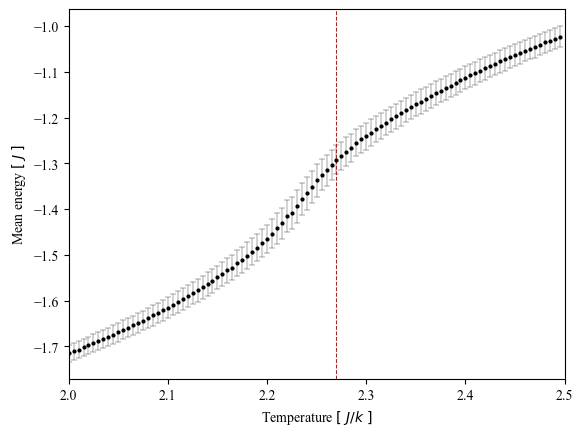

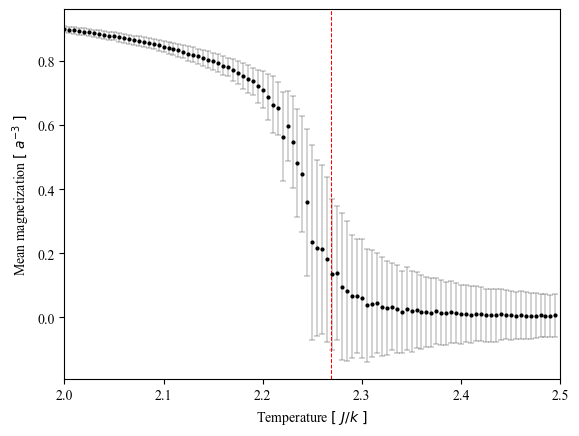

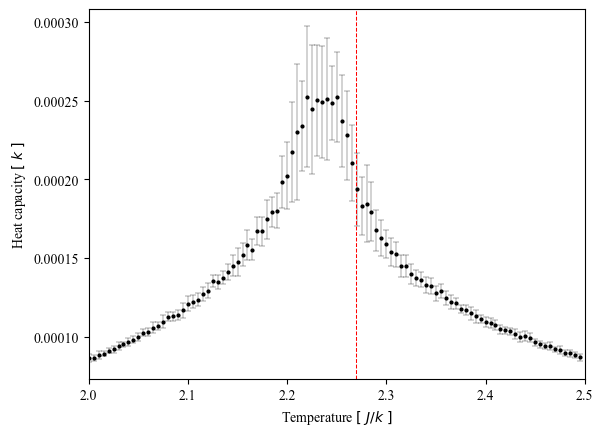

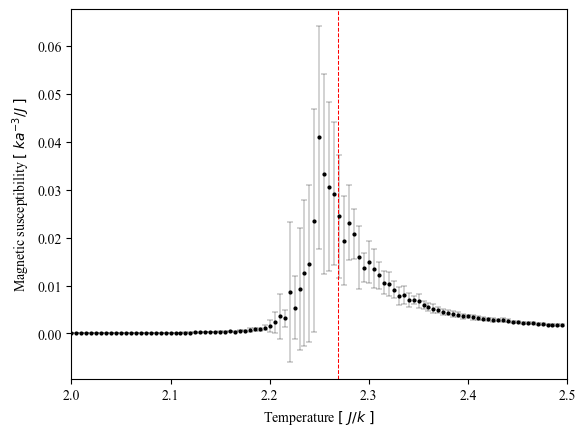

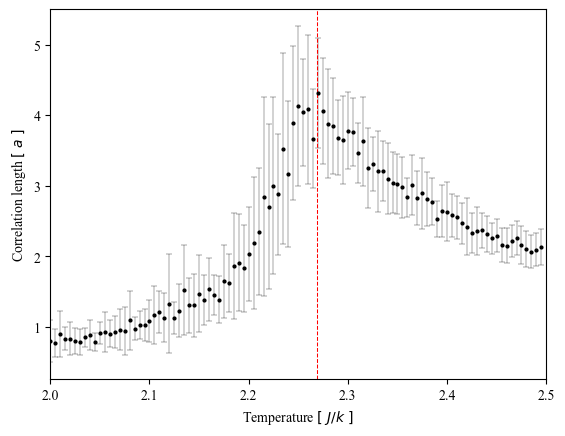

In [78]:
filepath = 'data/final'
identifier = 'final_2.00T2.50'

version_min = 0
version_max = 21

# Initialize lists to store results
Temp = []
E_mean = []
E_std = []
M_mean = []
M_std = []

for ver in range(version_min, version_max + 1):
    version = str(ver)

    EMfilename = identifier + '_EM_v' + version + '.csv'

    EMfile = filepath + '/' + EMfilename

    # Read the CSV file, skipping the first three rows
    data = pd.read_csv(EMfile, skiprows=3)

    # Drop the first two rows
    # data = data.drop([0, 1, 2])

    # Convert columns to numeric
    data = data.apply(pd.to_numeric)

    Temp.append(data['Temp'].values.tolist())
    E_mean.append(data['E_mean'].values.tolist())
    E_std.append(data['E_std'].values.tolist())
    M_mean.append(np.abs(data['M_mean']).values.tolist())
    M_std.append(data['M_std'].values.tolist())

Temp = np.array(Temp)
E_mean = np.array(E_mean)
E_std = np.array(E_std)
M_mean = np.array(M_mean)
M_std = np.array(M_std)

Temp = np.mean(Temp, axis=0)
Emm = np.mean(E_mean, axis=0)
Ems = np.std(E_mean, axis=0)
Esm = np.mean(E_std, axis=0)
Ess = np.std(E_std, axis=0)
Mmm = np.mean(M_mean, axis=0)
Mms = np.std(M_mean, axis=0)
Msm = np.mean(M_std, axis=0)
Mss = np.std(M_std, axis=0)

xi = []

for ver in range(version_min, version_max + 1):
    version = str(ver)
    SCfilename = identifier + '_SC_v' + version + '.csv'

    SCfile = filepath + '/' + SCfilename

    # Read the CSV file, skipping the first four rows
    corr = pd.read_csv(SCfile, skiprows=4, header=None)

    # Drop the first three rows
    # data = data.drop([0, 1, 2])

    # Convert columns to numeric
    corr = corr.apply(pd.to_numeric)

    corr = corr.values

    d = np.arange(corr.shape[1] - 1) + 1

    xmax = 49

    xvals = np.linspace(0, xmax, 1000)

    xi0 = []

    plotting_spatial_corr = False    # change to 'True' if want to plot 

    for Tctr in range(Temp.size):
        try:
            exparams, expcov = curve_fit(expCorr, d, corr[Tctr, 1:])

            xcrit = int(np.floor(exparams[0]/1))

            if plotting_spatial_corr:
                print(f'T = {Temp[Tctr]:.4f}')
                print(f'xi = {exparams[0]:.4f}')

            if xcrit > 0 and False:
                params, pcov = curve_fit(powerLaw, d[0: xcrit + 1], corr[Tctr, 1:xcrit + 2])
                if plotting_spatial_corr:
                    plt.plot(xvals[xvals<=xcrit], powerLaw(xvals[xvals<=xcrit], *params), color='orange')
                    print(f'eta = {2-2-params[0]:.4f}')
            else:
                if plotting_spatial_corr:
                    print('Power law not fitted.')

            if plotting_spatial_corr:
                plt.scatter(d, corr[Tctr, 1:])

                plt.xlabel('x')
                plt.ylabel('R(x)')
                plt.plot(xvals, expCorr(xvals, *exparams), color='red')
                plt.title(f'T={corr[Tctr, 0]:.3f}')
                plt.show()

        except RuntimeError:
            exparams = (np.nan,)
            expcov = (np.nan,)
        
        xi0.append(exparams[0])

    xi.append(xi0)

xi = np.array(xi)

xim = np.mean(xi, axis=0)
xis = np.std(xi, axis=0)

# Plot E_mean vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Emm, yerr=Esm, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')    # yerr = Esm or yerr = Ems

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)    # yerr = Msm or yerr = Mms

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Mean energy $[\ J\ ]$')
# plt.title('E_mean vs Temp')
plt.show()

# Plot M_mean vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Mmm, yerr=Msm, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Mean magnetization $[\ a^{-3}\ ]$')
# plt.title('M_mean vs Temp')
plt.show()

# Calculate Cv
Cv = (Esm ** 2) / (Temp ** 2)
Cverr = 2*Cv*Ess/Esm

# Plot Cv vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Cv, yerr=Cverr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('Specific Heat (Cv) vs Temp')
plt.show()

# Calculate chi
chi = (Msm ** 2) / Temp
chierr = 2*chi*Mss/Msm

# Plot chi vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, chi, yerr=chierr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('Magnetic Susceptibility (chi) vs Temp')
plt.show()

# Plot xi vs Temp
plt.errorbar(Temp, xim, yerr=xis, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
plt.show()

In [79]:
Tlo = Temp[Temp < Tc]
Thi = Temp[Temp > Tc]

tlo = (Tlo - Tc)/Tc
thi = (Thi - Tc)/Tc

Mmmlo = Mmm[Temp < Tc]
Mmmhi = Mmm[Temp > Tc]

Mmslo = Mms[Temp < Tc]
Mmshi = Mms[Temp > Tc]

Msmlo = Msm[Temp < Tc]
Msmhi = Msm[Temp > Tc]

Msslo = Mss[Temp < Tc]
Msshi = Mss[Temp > Tc]

Emmlo = Emm[Temp < Tc]
Emmhi = Emm[Temp > Tc]

Emslo = Ems[Temp < Tc]
Emshi = Ems[Temp > Tc]

Esmlo = Esm[Temp < Tc]
Esmhi = Esm[Temp > Tc]

Esslo = Ess[Temp < Tc]
Esshi = Ess[Temp > Tc]

Cvlo = Cv[Temp < Tc]
Cvhi = Cv[Temp > Tc]

Cverrlo = Cverr[Temp < Tc]
Cverrhi = Cverr[Temp > Tc]

chilo = chi[Temp < Tc]
chihi = chi[Temp > Tc]

chierrlo = chierr[Temp < Tc]
chierrhi = chierr[Temp > Tc]

xilo = xim[Temp < Tc]
xihi = xim[Temp > Tc]

xierrlo = xis[Temp < Tc]
xierrhi = xis[Temp > Tc]

In [80]:
Tmin = 2.00
Tmax = 2.50

Tmin1 = 2.15
Tmax1 = 2.39

Tmin1 = 2.25
Tmax1 = 2.29

# Tmin = 2.20
# Tmax = 2.34

# Tmin1 = Tc
# Tmax1 = Tc

beta = 0.13978143 +-0.00000079
Chi-square value: 179.381


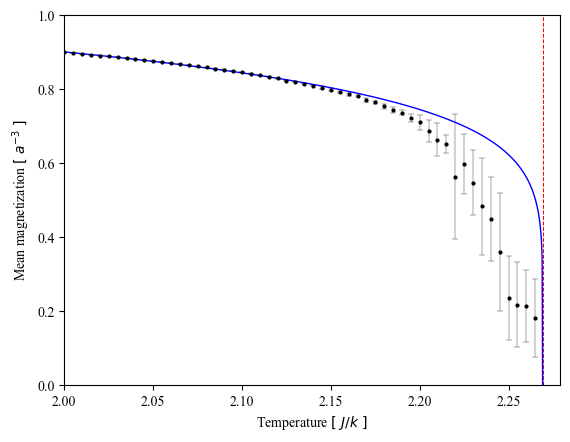

In [81]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
p0 = [beta0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, tlo[mask], Mmmlo[mask], p0 = p0, sigma = Mmslo[mask], absolute_sigma = True, full_output = True)
print(f'beta = {params[0]:.8f} +-{pcov[0,0]:.8f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.3f}')

# plt.figure(figsize=(10, 5))
mask = (Tmin <= Temp) & (Temp <= Tc)
plt.errorbar(Tlo[Tmin <= Tlo], Mmmlo[Tmin <= Tlo], yerr=Mms[mask], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), linewidth = 1, color = 'blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Mean magnetization $[\ a^{-3}\ ]$')

plt.xlim(Temp[0], Tc+0.01)
plt.ylim(0,1)

# plt.title('M_mean vs Temp')
plt.show()

(T<Tc) Chi-square value: 10.378
(Tc<T) Chi-square value: 6.061


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_99469/3876941249.py:8: RuntimeWarning: divide by zero encountered in log
  return A*np.log(np.abs(C*t))


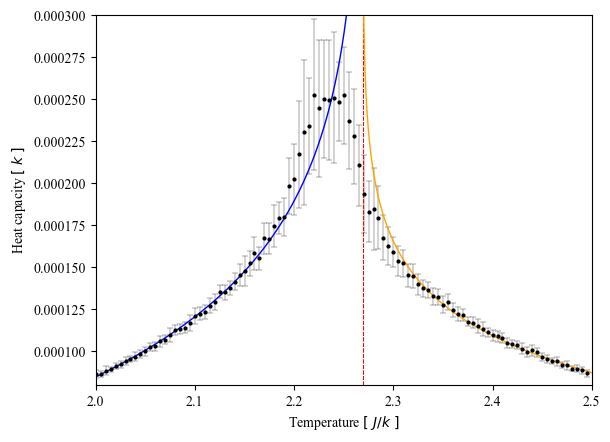

In [82]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
params, pcov, infodict, mesg, ier = curve_fit(logCv, tlo[mask], Cvlo[mask], sigma = Cverrlo[mask], absolute_sigma = True, full_output = True)

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'(T<Tc) Chi-square value: {chi_sq:.3f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Tlo[Tmin <= Tlo], Cvlo[Tmin <= Tlo], yerr=Cverrlo[Tmin <= Tlo], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, logCv((tvals-Tc)/Tc, *params), linewidth = 1, color = 'blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('M_mean vs Temp')

tvals = np.linspace(Tc, Tmax, 1000)

mask = (Thi <= Tmax) & (Tmax1 <= Thi)
params, pcov, infodict, mesg, ier = curve_fit(logCv, thi[mask], Cvhi[mask], sigma = Cverrhi[mask], absolute_sigma = True, full_output = True)

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'(Tc<T) Chi-square value: {chi_sq:.3f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Thi[Thi <= Tmax], Cvhi[Thi <= Tmax], yerr=Cverrhi[Thi <= Tmax], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, logCv((tvals-Tc)/Tc, *params), linewidth = 1, color = 'orange')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0.00008,0.0003)
plt.show()

(T<Tc) gamma = 2.3692 +-0.0040
Chi-square value: 4.75085
(Tc<T) gamma = 1.1229 +-0.0017
Chi-square value: 12.68971


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_99469/3876941249.py:2: RuntimeWarning: divide by zero encountered in power
  return A*np.power(np.abs(t), greek)


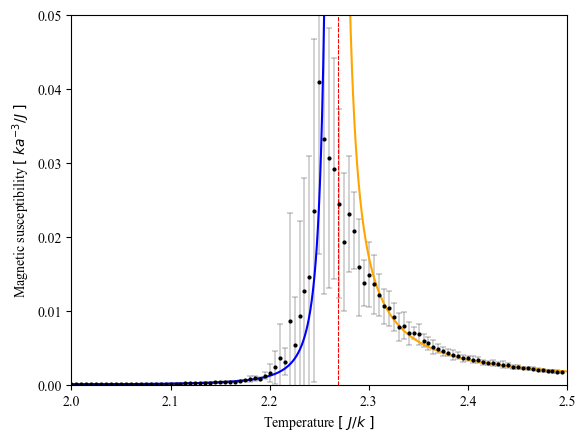

In [83]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
p0 = [-gamma0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, tlo[mask], chilo[mask], p0 = p0, sigma = chierrlo[mask], absolute_sigma = True, full_output = True)
print(f'(T<Tc) gamma = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Tlo[Tmin <= Tlo], chilo[Tmin <= Tlo], yerr=chierrlo[Tmin <= Tlo], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('M_mean vs Temp')

tvals = np.linspace(Tc, Tmax, 1000)

mask = (Thi <= Tmax) & (Tmax1 <= Thi)
p0 = [-gamma0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, thi[mask], chihi[mask], p0 = p0, sigma = chierrhi[mask], absolute_sigma = True, full_output = True)
print(f'(Tc<T) gamma = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Thi[Thi <= Tmax], chihi[Thi <= Tmax], chierrhi[Thi <= Tmax], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='orange')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0,0.05)
plt.show()

(T<Tc) nu = 0.6782 +-0.0035
Chi-square value: 2.55438
(Tc<T) nu = 0.3074 +-0.0012
Chi-square value: 3.24744


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_99469/3876941249.py:2: RuntimeWarning: divide by zero encountered in power
  return A*np.power(np.abs(t), greek)


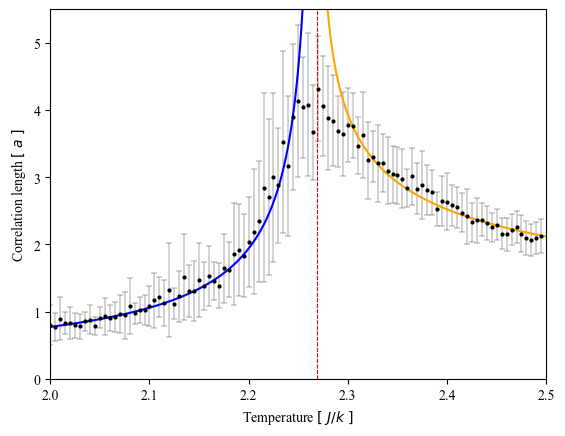

In [84]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
p0 = [-nu0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, tlo[mask], xilo[mask], p0 = p0, sigma = xierrlo[mask], absolute_sigma = True, full_output = True)
print(f'(T<Tc) nu = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Tlo[Tmin <= Tlo], xilo[Tmin <= Tlo], xierrlo[Tmin <= Tlo], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
# plt.title('M_mean vs Temp')

tvals = np.linspace(Tc, Tmax, 1000)

mask = (Thi <= Tmax) & (Tmax1 <= Thi)
p0 = [-nu0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, thi[mask], xihi[mask], p0 = p0, sigma = xierrhi[mask], absolute_sigma = True, full_output = True)
print(f'(Tc<T) nu = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Thi[Thi <= Tmax], xihi[Thi <= Tmax], xierrhi[Thi <= Tmax], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='orange')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0,5.5)
plt.show()